In [2]:
include("src/Sim.jl")

Main.Sim

In [3]:
using DifferentialEquations
using Plots
using .Sim

# 倒立振子

物理量

|物理量||数値と単位|
|:--:|:--:|:--:|
|$M$|台車の質量|$1kg$|
|$m$|棒の質量|$1kg$|
|$2l$|棒の長さ|$1.6m$|
|$g$|重力加速度|$9.8m/sec^2$|
|$F$|台車を押す力|$10N$|
|$x(t)$|台車の位置|-|
|$a(t)$|地面に対する垂線と棒のなす角度|-|

これらを用いて運動方程式を作ると<br>
## $(M+m)\ddot{x}(t) + ml\ddot{a}(t)\cos{a(t)} = F + ml\dot{a}(t)^2\sin{a(t)}$<br>
## $ml\ddot{x}(t)\cos{a(t)} + ml^2\ddot{a}(t) = mgl\sin{a(t)}$<br>

$\ddot{x}(t)と\ddot{a}(t)$について解くと<br>
## $\ddot{x}(t) = \frac{F + l\dot{a}(t)^2\sin{a(t)} - mg\sin{a(t)}\cos{a(t)}}{M + m\sin^2{a(t)}}$<br>
## $\ddot{a}(t) = \frac{(M + m)g\sin{a(t)} - (F + l\dot{a}(t)^2\sin{a(t)})\cos{a(t)}}{l(M + m\sin^2{a(t)})}$


In [3]:
@model model1 begin
    @parameter l M g m
    
    @blk In = InBlock()
    @blk Constant1 = ConstantBlock(l) outport:l_
    @blk Constant2 = ConstantBlock(m) outport:m_
    @blk Constant3 = ConstantBlock(g) outport:g_
    @blk Constant4 = ConstantBlock(M) outport:M_
    @blk Integrator1 = IntegratorBlock() inport:a_dot_dot outport:a_dot
    @blk Integrator2 = IntegratorBlock() outport:a
    @blk Add1 = AddBlock([:+, :+]) inport[1]:add1_1 inport[2]:add1_2
    @blk Add2 = AddBlock([:+, :-]) inport[1]:add2_1 inport[2]:add2_2
    @blk Add3 = AddBlock([:+, :+]) inport[1]:add3_1 inport[2]:add3_2
    @blk Add4 = AddBlock([:+, :-]) inport[1]:add4_1 inport[2]:add4_2
    @blk Add5 = AddBlock([:+, :+]) inport[1]:add5_1 inport[2]:add5_2
    @blk Division1 = DivisionBlock() inport[1]:div1_1 inport[2]:div1_2
    @blk Division2 = DivisionBlock() inport[1]:div2_1 inport[2]:div2_2
    @blk Out_x = OutBlock()
    @blk Out_a = OutBlock()
    
    @connect a_dot => Integrator2
    @connect In => add1_1
    @connect l_ * (a_dot)^2 * sin(a) => add1_2
    @connect Add1 => add2_1
    @connect m_ * g_ * sin(a) * cos(a) => add2_2
    @connect m_ * (sin(a))^2 => add3_1
    @connect M_ => add3_2
    
    @connect Add2 => div1_1
    @connect Add3 => div1_2
    @connect Division1 => Out_x
    #@connect Add2 / Add3 => Out_x
    
    @connect M_ => add5_1
    @connect m_ => add5_2
    @connect Add5 * g * sin(a) => add4_1
    @connect Add1 * cos(a) => add4_2
    
    @connect Add4 => div2_1
    @connect l_ * Add1 => div2_2
    @connect Division2 => Integrator1
    #@connect Add4 / (l_ * Add1) => Integrator1
    
    @connect a => Out_a
end

model1 (generic function with 1 method)

In [4]:
@model Testmodel1 begin
    #@parameter F
    @parameter l M g m
    
    #@blk Constant = ConstantBlock(F) outport:F
    @blk Ramp = RampBlock(slope=1, starttime=0.0, initialoutput=-5) outport:F
    #@blk Step = StepBlock(steptime=5, initialvalue=0, finalvalue=10) outport:F
    @blk iP = model1(l=l, m=m, g=g, M=M) outport[1]:x_dot_dot outport[2]:a
    @blk Out = OutBlock()
    
    #@connect sin(F) => iP
    @connect F => iP
    @connect sin(F) => Out
end

Testmodel1 (generic function with 1 method)

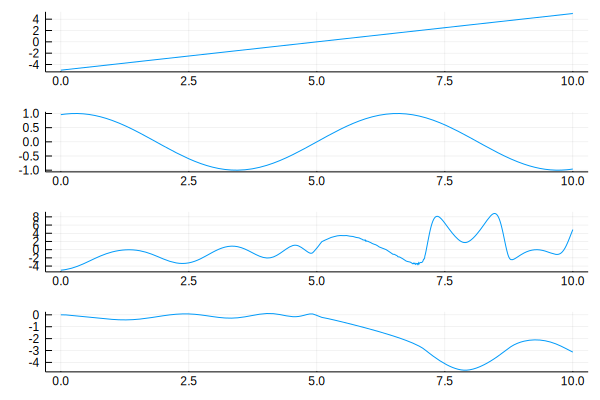

In [5]:
#m = Testmodel1(F=10, l=0.8, m=1, g=9.8, M=1)
m = Testmodel1(l=0.8, m=1, g=9.8, M=1)
sol = @simulate(m, tspan = (0.0, 10.0), scope=[F, Out, x_dot_dot, a])
sol.graph

In [1]:
using Images

In [2]:
using TestImages

In [3]:
using ImageView

In [4]:
img = load("BlockModel/invertedPendulum.png")
imshow(img)

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>32: "map(f-mapped image, input-2)…
  "annotations" => 2: "input-2" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => nothing

In [5]:
@model abc begin
    @parameter M m l g
    
    @blk Inte1 = IntegratorBlock() outport:x_d
    @blk Inte2 = IntegratorBlock() outport:x
    @blk Inte3 = IntegratorBlock() outport:theta_d
    @blk Inte4 = IntegratorBlock() outport:theta
    @blk Out1 = OutBlock()
    @blk Out2 = OutBlock()
    @blk Trigo1 = TrigonometricFunctionBlock(:sin)
    @blk Trigo2 = TrigonometricFunctionBlock(:cos)
    @blk Math1 = MathFunctionBlock(:square)
    @blk Math2 = MathFunctionBlock(:square)
    @blk Math3 = MathFunctionBlock(:reciprocal)
    @blk Gain1 = GainBlock(l)
    @blk Gain2 = GainBlock(g)
    @blk Gain3 = GainBlock(1/l)
    @blk Add1 = AddBlock([:+, :+]) inport[1]:add1_1 inport[2]:add1_2
    @blk Add2 = AddBlock([:+, :+]) inport[1]:add2_1 inport[2]:add2_2
    @blk Add3 = AddBlock([:+, :-]) inport[1]:add3_1 inport[2]:add3_2
    @blk Add4 = AddBlock([:+, :+, :-]) inport[1]:add4_1 inport[2]:add4_2 inport[3]:add4_3
    @blk In = InBlock()
    @blk Const1 = ConstantBlock(M) outport:M
    @blk Const2 = ConstantBlock(m) outport:m
    
    @connect x_d => Inte2
    @connect x => Out1
    
    @connect theta_d => Inte4
    @connect theta => Out2
    
    #A
    @connect M => add1_1
    @connect theta => Trigo1
    @connect Trigo1 => Math1
    @connect m * Math1 => add1_2
    @connect Add1 => Math3
    
    #B
    @connect theta_d => Math2
    @connect Trigo1 * Math2 => Gain1
    @connect Gain1 => add2_1
    @connect In => add2_2
    @connect Add2 => add3_1
    
    #C
    @connect theta => Trigo2
    @connect Add2 * Trigo2 => add4_3
    
    #D
    @connect Trigo1 => Gain2
    @connect Gain2 * m * Trigo2 => add3_2
    
    #E
    @connect Gain2 * m => add4_1
    
    #F
    @connect Gain2 * M => add4_2
    
    @connect Add3 * Math3 => Inte1
    @connect Math3 => Gain3
    @connect Gain3 * Add4 => Inte3
end
    

abc (generic function with 1 method)

In [6]:
@model abcd begin
    @parameter f
    @parameter M m l g
    
    @blk Const = ConstantBlock(f) outport:F
    #@blk Ramp = RampBlock(slope=1, starttime=0.0, initialoutput=0.0) outport:F
    #@blk Trigo = TrigonometricFunctionBlock(:sin) outport:sinF
    @blk Modelabc = abc(M=M, m=m, l=l, g=g) outport[1]:x outport[2]:theta
    
    @connect F => Modelabc
    
    #@connect F => Trigo
    #@connect Trigo => Modelabc
end

abcd (generic function with 1 method)

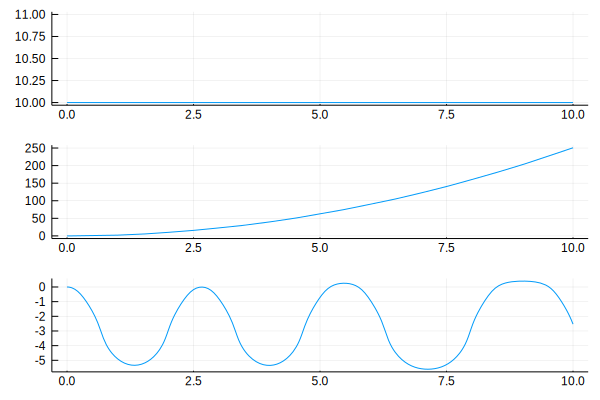

In [7]:
m = abcd(f=10, M=1, m=1, l=0.8, g=9.8)
#m = abcd(M=1, m=1, l=0.8, g=9.8)
sol = @simulate(m, tspan = (0.0, 10.0), scope=[F, x, theta])
#sol = @simulate(m, tspan = (0.0, 10.0), scope=[sinF, x, theta])
sol.graph

|物理量||数値と単位|
|:--:|:--:|:--:|
|$M$|台車の質量|$0.5kg$|
|$m$|棒の質量|$0.2kg$|
|$l$|棒の中心から端までの長さ|$0.3m$|
|$b$|台車の摩擦係数|$0.1/N/m/sec$|
|$g$|重力加速度|$9.8m/sec^2$|
|$I$|振り子の質量慣性モーメント|$0.006kg　m^2$|
|$F$|台車を押す力|-|
|$x(t)$|台車の位置|-|
|$theta(x)$|垂線と棒のなす角度(下)|-|

運動方程式は以下のようになる
## $M\ddot{x}(t) = F - N - b\dot{x}$<br>
## $I\ddot{\theta}(t) = -Nl\cos{\theta} - Pl\sin{\theta}$<br>

ここで$N$と$P$は棒と台車の間に働く力でそれぞれ地面と水平方向、垂直方向の力である.
棒に注目すると
# $m\ddot{x_p} = N$<br>
# $m\ddot{y_p} = P - mg$<br>

$x_p,y_p$を書きかえると
# $x_p = x + l\sin{\theta}$
# $\dot{x_p} = \dot{x} + l\dot{\theta}\cos{\theta}$
# $\ddot{x_p} = \ddot{x} - l\dot{\theta}^2\sin{\theta} + l\ddot{\theta}\cos{\theta}$<br>

# $y_p = - l\cos{\theta}$
# $\dot{y_p} = l\dot{\theta}\sin{\theta}$
# $\ddot{y_p} = l\dot{\theta}^2\cos{\theta} + l\ddot{\theta}\sin{\theta}$<br>

となるので、$N$と$P$は以下のように表せる
# $N = m(\ddot{x} - l\dot{\theta}^2\sin{\theta} + l\ddot{\theta}\cos{\theta})$
# $P = m(l\dot{\theta}^2\cos{\theta} + l\ddot{\theta}\sin{\theta} + g)$

In [10]:
@model PIController begin
    @parameter kc Ti
    
    #@blk Const = ConstantBlock(r)
    @blk In1 = InBlock() outport:r
    @blk In2 = InBlock() outport:y
    @blk Add1 = AddBlock([:+, :-]) inport[1]:add1_1 inport[2]:add1_2
    @blk Inte = IntegratorBlock()
    @blk Gain1 = GainBlock(Ti)
    @blk Add2 = AddBlock([:+, :+]) inport[1]:add2_1 inport[2]:add2_2
    @blk Gain2 = GainBlock(kc)
    @blk Out = OutBlock()
    
    @connect r => add1_1
    @connect y => add1_2
    @connect Add1 => add2_1
    @connect Add1 => Inte
    @connect Inte => Gain1
    @connect Gain1 => add2_2
    @connect Add2 => Gain2
    @connect Gain2 => Out
end

PIController (generic function with 1 method)

In [11]:
@model abcController begin
    @parameter SV
    @parameter kc Ti
    @parameter M m l g
    
    @blk Const = ConstantBlock(SV)
    @blk PIC = PIController(kc=kc, Ti=Ti) inport[1]:r inport[2]:y outport:u
    @blk Modelabc = abc(M=M, m=m, l=l, g=g) outport[1]:x outport[2]:theta
    
    @connect Const => r
    @connect u => Modelabc
    @connect theta => y
end

abcController (generic function with 1 method)

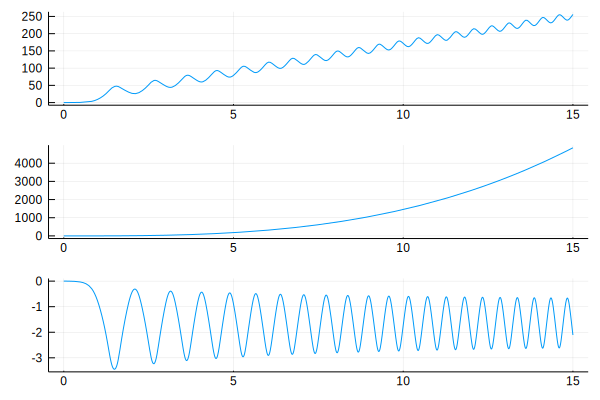

In [32]:
m = abcController(SV=0.01, kc=10, Ti=1.0, M=1, m=1, l=0.8, g=9.8)

sol = @simulate(m, tspan = (0.0, 15.0), scope=[u, x, theta])

sol.graph